In [5]:
import torch
print(torch.cuda.is_available())   # Should return True
print(torch.cuda.get_device_name(0))  # Should show RTX 4060


True
NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Standard image transforms for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Single channel X-rays, normalized
])

# Paths to Stage 1 data
stage1_base = "../Dataset/stage1"

# Load datasets
train_ds1 = datasets.ImageFolder(f"{stage1_base}/train", transform=transform)
val_ds1 = datasets.ImageFolder(f"{stage1_base}/val", transform=transform)
test_ds1 = datasets.ImageFolder(f"{stage1_base}/test", transform=transform)

# Create DataLoaders
train_loader1 = DataLoader(train_ds1, batch_size=32, shuffle=True)
val_loader1 = DataLoader(val_ds1, batch_size=32, shuffle=False)
test_loader1 = DataLoader(test_ds1, batch_size=32, shuffle=False)

# Class mapping
print("Stage 1 Classes:", train_ds1.classes)


Stage 1 Classes: ['Corona Virus Disease', 'Normal', 'Pneumonia', 'Tuberculosis']


In [7]:
from transformers import ViTForImageClassification

# Load pretrained ViT and customize for 4 classes
model1 = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=4
)

# Move to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1.to(device)

# Check architecture summary
print(model1)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [8]:

from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import numpy as np

# Hyperparameters
num_epochs = 15  # Max number of epochs before early stopping
lr = 2e-5
patience = 3  # Number of epochs with no improvement to wait before stopping

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model1.parameters(), lr=lr)

# Early stopping variables
best_val_loss = np.inf
epochs_without_improvement = 0
best_model_path = "../Model/best_model_stage1.pth"

for epoch in range(num_epochs):
    model1.train()
    total_loss = 0

    loop = tqdm(train_loader1, desc=f"Epoch {epoch+1}/{num_epochs}")

    # Training loop
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model1(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader1)
    print(f"Epoch {epoch+1} finished. Avg Train Loss: {avg_train_loss:.4f}")

    # Validation
    model1.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader1:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader1)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset patience counter
        # Save the best model
        torch.save(model1.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1}.")
    else:
        epochs_without_improvement += 1

    # Stop early if no improvement for `patience` epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


Epoch 1/15:   3%|▎         | 5/190 [00:09<05:37,  1.83s/it, loss=1.33]


KeyboardInterrupt: 

In [9]:
# Load best model
model1.load_state_dict(torch.load("../Model/best_model_stage1.pth",weights_only=True))
model1.to(device)
model1.eval()

# Evaluate on test set
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader1:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images).logits
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f" Final Test Accuracy (Stage 1): {test_accuracy:.2f}%")


✅ Final Test Accuracy (Stage 1): 97.88%


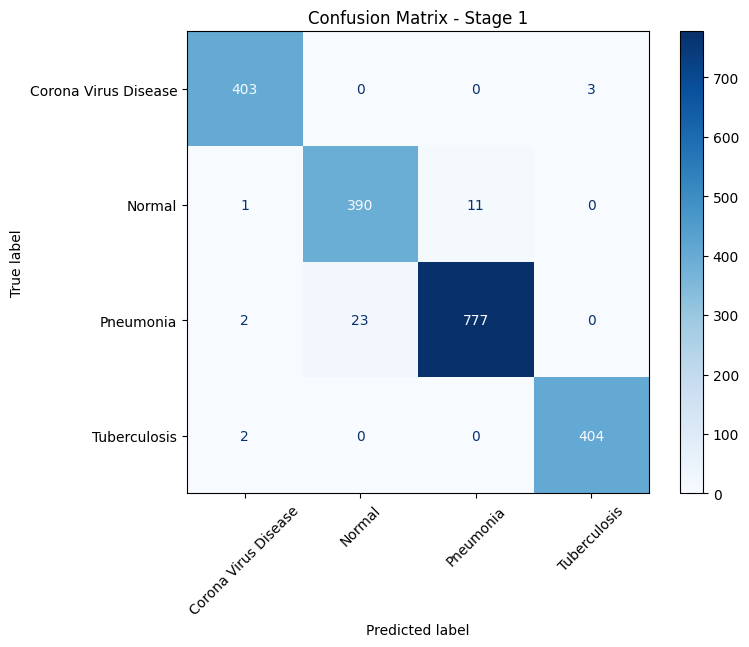

In [10]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model1.eval()

true_labels = []
pred_labels = []

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in val_loader1:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs.logits, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Define class names in the required order
class_names = ['Corona Virus Disease', 'Normal', 'Pneumonia', 'Tuberculosis']

# Generate and plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - Stage 1")
plt.grid(False)
plt.show()
